In [1]:
import sys
sys.path.append("../behavioral_cloning")
sys.path.append("../")
from build_dataset import *
import seaborn as sbn
import numpy as np
import load_policy

### Load & prep humanoid dataset

In [2]:
# train_observations, train_actions = load_expert_data("../expert_data/train/Humanoid-v2.pkl")
# test_observations, test_actions = load_expert_data("../expert_data/test/Humanoid-v2.pkl")
train_observations, train_actions = load_expert_data("../expert_data/train/HalfCheetah-v2.pkl")
test_observations, test_actions = load_expert_data("../expert_data/test/HalfCheetah-v2.pkl")

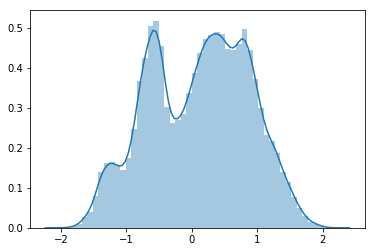

In [3]:
sbn.distplot(train_actions.ravel())

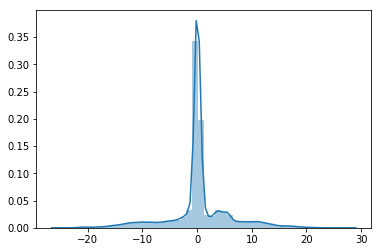

In [65]:
sbn.distplot(train_observations.ravel())

In [3]:
train_dataset = build_in_mem_tf_dataset(train_observations, train_actions).shuffle(20000).batch(64)
test_dataset = build_in_mem_tf_dataset(test_observations, test_actions).batch(64)
train_dataset

<BatchDataset shapes: ((None, 17), (None, 12)), types: (tf.float64, tf.float32)>

In [18]:
train_dataset.element_spec[1].shape[-1]

12

### Define model

In [4]:
model = tf.keras.Sequential([
    # tf.keras.layers.Flatten(), # (B x 376)
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(12, activation="tanh")
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_squared_error'])


In [5]:
model.fit(train_dataset, epochs=30)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

313/313 [==============================] - 0s 1ms/step - loss: 0.0227 - mean_squared_error: 0.0227
Epoch 2/30
313/313 [==============================] - 0s 967us/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 3/30
313/313 [==============================] - 0s 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 4/30
313/313 [==============================] - 0s 1ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 5/30
313/313 [==============================] - 0s 1ms/step 

In [6]:
model.evaluate(test_dataset)

79/79 [==============================] - 0s 2ms/step - loss: 4.3378e-04 - mean_squared_error: 4.3378e-04


[0.00043378453119657934, 0.00043378453119657934]

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1212      
Total params: 23,212
Trainable params: 23,212
Non-trainable params: 0
_________________________________________________________________


### Test in Gym env

In [8]:
def decode_cos_sin(a):
    dim = a.shape[1]
    return 2*np.arctan(np.divide(a[:, dim//2:], a[:, :dim//2]))

# decode_cos_sin(action)

In [19]:
# for o, a in test_dataset:
#     a_predict = model.predict(o)
#     print(a_predict)
#     print(a)
#     break

    
import gym
# env = gym.make("Humanoid-v2")
env = gym.make("HalfCheetah-v2")
max_steps = env.spec.timestep_limit
print(max_steps)
expert_policy_fn = load_policy.load_policy("../experts/HalfCheetah-v2.pkl")

returns = []
observations = []
actions = []
for i in range(5):
    print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
#         action = decode_cos_sin(model.predict(obs[None,:]))
        action = decode_cos_sin(model.predict(obs[None,:]))
        expert_action = expert_policy_fn(obs[None, :])
#         encoded = cos_sin_encoding(expert_action)
#         decoded = decode_cos_sin(encoded)
#         print(action)
#         print(decode_cos_sin(action))
#         print(expert_action)
#         print("encode", encoded)
#         print("decode", decoded)
#         input()
        
        #observations.append(obs)
        actions.append(action)
        obs, r, done, _ = env.step(action)
#         print("r:", r)
        totalr += r
        steps += 1
        if True:
            env.render()
        if steps % 100 == 1:
            print("%i/%i"%(steps, max_steps))
#             print(action, expert_action)
        if steps >= max_steps:
            break
    print("total:", totalr, steps)
    # print("Average reward: %.2f" % (float(totalr)/steps))
#     returns.append(totalr)

/Users/shawnlin/.pyenv/versions/3.5.10/envs/3.5-RL/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1000
iter 0
Creating window glfw
1/1000
101/1000
201/1000
301/1000
401/1000
501/1000
601/1000
701/1000
801/1000
901/1000
total: 3953.901803943034 1000
iter 1
1/1000
101/1000
201/1000
301/1000
401/1000
501/1000
601/1000
701/1000
801/1000
901/1000
total: 4009.8593303453786 1000
iter 2
1/1000
101/1000
201/1000
301/1000
401/1000
501/1000
601/1000
701/1000
801/1000
901/1000
total: 4054.0328038522744 1000
iter 3
1/1000
101/1000
201/1000
301/1000
401/1000
501/1000
601/1000
701/1000
801/1000
901/1000
total: 4051.243492472331 1000
iter 4
1/1000
101/1000
201/1000
301/1000
401/1000
501/1000
601/1000
701/1000
801/1000
901/1000
total: 4129.3581216501925 1000


### Dagger Improvement

In [39]:
action = (model.predict(obs[None,:]))
action.shape
action
# expert_action = expert_policy_fn(obs[None, :])
# encoded = cos_sin_encoding(expert_action)
# decoded = decode_cos_sin(encoded)

array([[ 2.0833359e+00,  2.1694973e-03, -4.6381602e-01, -2.2720672e-01,
        -6.9744051e-02,  2.8807750e+00,  1.9305988e-01, -2.3208709e-01,
         3.3280158e-01,  2.6169517e+00,  8.9953852e-01,  6.0308278e-01,
        -2.0367348e+00,  5.0216019e-01, -6.5781331e-01,  5.1286876e-02,
         6.7601019e-01]], dtype=float32)

In [44]:
a = cos_sin_encoding(action)
# decode_cos_sin(a)
print(a[:, :17], a[:, 17:])

tf.Tensor(
[[-0.49039206  0.9999977   0.89435184  0.97429943  0.99756885 -0.96617943
   0.98142177  0.97318846  0.9451308  -0.8655038   0.62197137  0.82359105
  -0.44926143  0.87654483  0.79133105  0.9986851   0.7800753 ]], shape=(1, 17), dtype=float32) tf.Tensor(
[[ 0.8715019   0.0021695  -0.4473642  -0.22525692 -0.06968752  0.25787067
   0.19186282 -0.23000915  0.32669216  0.5009023   0.78304     0.5671841
  -0.8934003   0.48132017 -0.6113879   0.05126439  0.62568563]], shape=(1, 17), dtype=float32)


In [46]:
aa = np.divide(a[:, -17:], a[:, :17])
aa

array([[-1.7771534 ,  0.0021695 , -0.5002105 , -0.23119886, -0.06985736,
        -0.2668973 ,  0.19549477, -0.23634595,  0.34565815, -0.5787407 ,
         1.2589647 ,  0.688672  ,  1.9885979 ,  0.5491107 , -0.77260697,
         0.05133189,  0.8020836 ]], dtype=float32)

In [47]:
np.arctan(aa)

array([[-1.0582567 ,  0.0021695 , -0.46381602, -0.22720672, -0.06974406,
        -0.26081768,  0.19305988, -0.23208709,  0.33280158, -0.524641  ,
         0.8995385 ,  0.6030828 ,  1.1048578 ,  0.5021602 , -0.6578133 ,
         0.05128688,  0.67601013]], dtype=float32)

In [31]:
expert_action = expert_policy_fn(obs[None, :])
expert_action

<tf.Tensor: shape=(1, 17), dtype=float64, numpy=
array([[ 2.06533211,  0.02771716, -0.33934712, -0.34991579, -0.01315385,
         2.78224855,  0.26335697, -0.30198193,  0.30649744,  2.46249705,
         1.03022721,  0.57392961, -1.92479813,  0.57156432, -0.65316731,
        -0.04659016,  0.59989793]])>